### Training an Image Classifier 
The following code has been adapted from various sources including: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-3-CNNs-and-image-classification/train-image-classifier-from-pretrained.ipynbdebugged andareas have been debugged using GPT.
In this notebook I clean my image dataset, create new data points for each image and implement these changes back into my 'emtional-class-datasheet.csv'. 
Additionally, I implement ResNet and VisionTransformer for training.

In [5]:
%pip install pandas
%pip install opencv-python
%pip install torch torchvision
%pip install numpy
%pip install matplotlib
%pip install pytesseract
%pip install scikit-learn
%pip install dlib
%pip install opencv-python
%pip install cmake
%pip install --upgrade numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.1.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-2.1.1-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not

In [ ]:
%pip uninstall opencv-python
%pip uninstall opencv-python-headless



In [6]:
import sys
sys.setrecursionlimit(1500)


In [3]:
import os
import pandas as pd
import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import pytesseract

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split



In [8]:
# Double check my class datasets are recognised:
os.listdir('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset')

['neutral-face', 'happy-face', 'sad-face', 'angry-face']

In [9]:
# I had an unexpected file in my class dataset ('.ipynb_checkpoints') and wanted to double chheck the conentss, if any.
directory_path = '/Users/nixi/Desktop/Final thesis folder 24/AI-for-Media-project-23-24/my-classification-dataset'

# List the contents of the directory
contents = os.listdir(directory_path)

if '.ipynb_checkpoints' in contents:
    checkpoint_path = os.path.join(directory_path, '.ipynb_checkpoints')
    checkpoint_contents = os.listdir(checkpoint_path)
    print(checkpoint_contents)
else:
    print(".ipynb_checkpoints directory does not exist in the specified directory.")
    # This created an empty list, nothing to worry about!

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nixi/Desktop/Final thesis folder 24/AI-for-Media-project-23-24/my-classification-dataset'

## Data Pre-Processing
### A. Remove any duplicates in 'my-classification-dataset' 
I had noticed a few duplicates when woorking with the same custom dataset for another data science module for k-means cluster experimentation. The private repository can be found here: https://git.arts.ac.uk/23002156/Intro-Data-Science-Portfolio-2024.
### B. Isolating faces from images ( particularly for magazine data and to remove solely text data thta may have been collected during sampling)
I could exclude images with text using a text detector, but this may reduce the dataset significantly.
Use Haar Cascade classifier ( which uses feature based object detection) available from: https://github.com/opencv/opencv/tree/4.x/data/haarcascades.
### C. Create 'emotional-class-datasheet.csv', considering any new changes


In [11]:
%pip install dlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
import dlib
import cv2
import pandas as pd
import os

In [13]:

# The following code has been adapted from Week 4,Sensing bodies : https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/commit/981594f418f30d02fcff4998cc93f39d4108b608 and debugged using GPT
# Isolate faces using Haar Casscade Classifier, I learnt how to implement this classifier from: https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php

# Initialize the face cascade and shape predictor
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
predictor_path = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

# Path to the directory containing your images
directory_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'

data = []

# Iterate over all files in the directory, as adapted from: https://www.slingacademy.com/article/python-how-to-iterate-over-all-files-in-a-directory/
for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if filename.lower().endswith('.jpg') or filename.lower().endswith('.png'):
            # Build the full file path
            image_path = os.path.join(root, filename)
            print("Processing image:", image_path)
            
            # Load the image
            image = cv2.imread(image_path)
            
            # Check if the image was loaded properly
            if image is None:
                print(f"Error loading image {image_path}. Skipping...")
                continue

            # Convert the image to grayscale for feature extraction, which helps to reduce any noise when the images are processed and hopefully better training.
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # If no faces are detected
            if len(faces) == 0:
                print("No faces detected in", image_path)
                # Remove the file from the directory
                os.remove(image_path)
                print(image_path, "removed from dataset")
                continue

            # Extract emotion class from the directory path
            emotion_class = os.path.basename(root)

             # Next I need to find eye, mouth and nose landmark points for each image. I started with creating variables to store the data.
            # Code debugged  using GPT and adapted from https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-4-Sensing-bodies and https://dontrepeatyourself.org/post/how-to-detect-face-landmarks-with-dlib-python-and-opencv/?utm_content=cmp-true
            for (x, y, w, h) in faces:
                face_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
                landmarks = predictor(gray, face_rect)

                # Initialize lists for landmarks
                eyes_x, eyes_y, nose_x, nose_y, mouth_x, mouth_y = [], [], [], [], [], []

                # Extract landmark coordinates for eyes
                for n in range(36, 48):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    eyes_x.append(x)
                    eyes_y.append(y)

                # Extract landmark coordinates for nose
                for n in range(27, 35):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    nose_x.append(x)
                    nose_y.append(y)

                # Extract landmark coordinates for mouth
                for n in range(48, 68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    mouth_x.append(x)
                    mouth_y.append(y)

                # Append extracted features to the list
                data.append({
                    'Image': filename, 
                    'EmotionClass': emotion_class, 
                    'TotalFaceArea': w * h,
                    'EyesX': eyes_x, 
                    'EyesY': eyes_y, 
                    'NoseX': nose_x, 
                    'NoseY': nose_y,
                    'MouthX': mouth_x, 
                    'MouthY': mouth_y
                })

# Create a DataFrame to store the data
df = pd.DataFrame(data)

# Write the data to a CSV file
df.to_csv('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/facial_landmarks_data.csv', index=False)

# Indicate that processing is complete
print("Data processing complete.")

Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_370491506865098460.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655987.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655978.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_31806741112770968.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002237.210_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655950.jpg
Processing image: /Users/nixi/D

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_539657967902865008.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986322.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986444.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751656136.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_446700856785060544.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1125968643142283.jpg
Processing image: /Users/nixi/Desktop/F

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986424.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_90635011241421336.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-05T231324.567_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986168.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_37365871902587893.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_61572719892677896.jpg
Processing image: /Users/nixi/Desk

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/26559693133_d2eed3bb11_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_648870258845585156.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002057.649_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_219832025557833299.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655922.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655936.jpg
Processing image: /Users/nixi/

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_19914423346149273.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_15199717488061676.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655894.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986186.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986435.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986409.jpg
Processing image: /Users/nixi/Desktop/

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_201043570861003667.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_115967759147805878.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_27373510229639307.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655695.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_3659243437933905.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_4503668371894745.jpg
Processing image: /Users/nixi/Desktop/Final-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_207728601556170946.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_16888567431902409.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_75646468732444007.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T003055.324_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_4222193393249724.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_14707136270391208.jpg
Processing image: /Users/nixi/Desktop/

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_21321798219088645.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986374.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986406.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_49117452180873979.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_604960162478979903.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002318.349_face.png
Processing image: /Users/nixi/Des

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_703756187362095.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_246712885830603527.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986207.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_16044142415947743.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_633387431828995.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986398.jpg
Processing image: /Users/nixi/Desktop/Final-t

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1900024838020632.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_669206825900764519.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655889.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_573716440003454151.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_46302702413901894.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_769341548867251897.png
Processing image: /Users/nixi/Desktop/Fina

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_180355160061033841.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_2322237301177320.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_68747861412.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1407443619132982.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_50032245853397464.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002854.499_face.png
Processing image: /Users/nixi/Desktop/Final-t

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_569494315351356831.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253069693496.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/364961554_995f805895_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253086036981.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352438544542.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071809477.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-fo

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434484842.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071957871.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352441127812.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_371406300532270293.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352441072191.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253069897189.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-f

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434496211.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253072407043.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434498228.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_429812358183417538.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_43136108914764385.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071829071.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-fo

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352443351347.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_880735270883642827.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253070148038.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954848096570.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images (66)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_213709944804842420.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Me

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954851240250.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_644366659205693589.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200543.221_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847755604.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_430516045647009653.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200115.374_face.png
Processing image: /Users/nixi/Desktop/Final-thesis

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S127_010_00000016.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003650.711_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_932456297835319036.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751986920.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_83738874315289727.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_5770305764491637.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_794181715567162541.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004112.693_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_649855421204676105.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751986932.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S126_008_00000028.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T005954.493_face.png
Processing image: /Users/nixi/Desktop/Final-thes

In [11]:
# Code adapted from: https://www.geeksforgeeks.org/reading-image-opencv-using-python/?ref=lbp 
# Remove Duplicates:

import hashlib

folder_path = '/Users/nixi/Desktop/Final thesis folder 24/AI-for-Media-project-23-24/my-classification-dataset'

# Load CSV file
csv_file_path = 'emotional-class-datasheet.csv'
data = pd.read_csv(csv_file_path)

# Initialize a dictionary to store file hashes
file_hashes = {}

# Iterate through the subfolders
for subdir, dirs, files in os.walk(folder_path):
    # Iterate through the files in each subfolder
    for filename in files:
        file_path = os.path.join(subdir, filename)
        
        # Calculate the hash of the file content
        with open(file_path, 'rb') as file:
            file_hash = hashlib.md5(file.read()).hexdigest()
        
        # Check for duplicates based on file content
        if file_hash in file_hashes.values():
            # Remove duplicate file
            os.remove(file_path)
            # Remove corresponding row from CSV
            data = data[data['Image URL'] != file_path]
        else:
            file_hashes[filename] = file_hash

# Save the updated data to the CSV file
data.to_csv(csv_file_path, index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'emotional-class-datasheet.csv'

##### Additional images derrived from https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?select=anger to ensure the ratio of images for each emotional class ,after cleaning, is over 1000 at the least.This aids in removing bias and better overall classification.

In [4]:
# How has this impacted my ratio?
emotional_classes = ['neutral-face', 'happy-face', 'sad-face', 'angry-face']

dirrectory = "/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset"

#Instantiate for counts
class_counts = {}

for emotion in emotional_classes:
    class_dir = os.path.join(dirrectory, emotion)
    # Count the number of image files in the class directory
    class_counts[emotion] = len([file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


# Print out the value of each folder
for emotion_class, count in class_counts.items():
    print(f"Emotional class: {emotion_class}, Total images: {count}")

Emotional class: neutral-face, Total images: 968
Emotional class: happy-face, Total images: 1037
Emotional class: sad-face, Total images: 774
Emotional class: angry-face, Total images: 842


In [13]:
df_cleaned = df.dropna(subset=['EmotionClass'])

#df = df.drop(columns=['Path', 'NumFaces'])

# Step 2: Inspect NaN values
print("NaN values in each column before cleaning:")
print(df.isna().sum())

# Step 3: Drop rows with NaN values in the 'EmotionClass' column
df_cleaned = df.dropna(subset=['EmotionClass'])

# Step 4: Fill remaining NaN values in specified columns
df_cleaned = df_cleaned.fillna({
    'EyesX': '',
    'EyesY': '',
    'NoseX': '',
    'NoseY': '',
    'MouthX': '',
    'MouthY': ''})

df_cleaned


NameError: name 'df' is not defined

In [46]:
# Reduce the sample to remove bias in model training to predict emotions.

import random
import shutil

emotional_classes = ['neutral-face', 'happy-face', 'sad-face', 'angry-face']

# Directory containing the images
directory = "AI-for-Media-project-23-24/my-classification-dataset"

# Output directory for reduced image sets
output_dir = "/notebooks/AI-for-Media-project-23-24/reduced-dataset"
os.makedirs(output_dir, exist_ok=True)

# Count and reduce images
for emotion in emotional_classes:
    class_dir = os.path.join(directory, emotion)
    images = [file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))]
    
    # Randomly select up to 1500 images
    selected_images = random.sample(images, min(len(images), 1500))
    
    # Create output directory for the emotion class
    class_output_dir = os.path.join(output_dir, emotion)
    os.makedirs(class_output_dir, exist_ok=True)
    
    # Copy selected images to the output directory
    for image in selected_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(class_output_dir, image))
    
    # Print out the value of each folder
    print(f"Emotional class: {emotion}, Total images after reduction: {len(selected_images)}")

print("Image selection and saving completed.")

OSError: [Errno 30] Read-only file system: '/notebooks'

## Make the training and validation set for training
I experimented with how to best split my dataset into train and validation sets, while maintaining the directory structure. I tried manually doing so, then using 'random_state= 42' as used in the class workbook which split data in a deterministic way. (See https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-3-CNNs-and-image-classification).

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'
output_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24'
train_ratio = 0.8

# Create output directories for train and validation sets
train_output_path = os.path.join(output_path, 'train')
val_output_path = os.path.join(output_path, 'validation')
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# Dictionary to hold file paths by emotion class
class_files = {}

# Collect image and label files by emotion class
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.txt'):
            class_name = os.path.basename(root)
            if class_name not in class_files:
                class_files[class_name] = {'images': [], 'labels': []}
            file_path = os.path.join(root, f)
            if f.endswith('.jpg') or f.endswith('.png'):
                class_files[class_name]['images'].append(file_path)
            elif f.endswith('.txt'):
                class_files[class_name]['labels'].append(file_path)

# Perform train-test split for each class separately and copy the files
for class_name, files in class_files.items():
    train_image_files, val_image_files = train_test_split(files['images'], test_size=1 - train_ratio, random_state=42)
    train_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in train_image_files]
    val_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in val_image_files]

    # Copy training image and label files to the appropriate directory
    for train_image_file in train_image_files:
        relative_dir = os.path.relpath(os.path.dirname(train_image_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_image_file, os.path.join(target_dir, os.path.basename(train_image_file)))

    for train_label_file in train_label_files:
        relative_dir = os.path.relpath(os.path.dirname(train_label_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_label_file, os.path.join(target_dir, os.path.basename(train_label_file)))

    # Copy validation image and label files to the appropriate directory
    for val_image_file in val_image_files:
        relative_dir = os.path.relpath(os.path.dirname(val_image_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_image_file, os.path.join(target_dir, os.path.basename(val_image_file)))

    for val_label_file in val_label_files:
        relative_dir = os.path.relpath(os.path.dirname(val_label_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_label_file, os.path.join(target_dir, os.path.basename(val_label_file)))

print("Data split into train and validation sets for each class.")

Data split into train and validation sets for each class.


In [6]:
# I had a folder called 'ipynb_checkpoints' that was considered a 7th emotional class but had no data within. This prevented the above code from working because file formats listed were not found at all.
# This seemed to be a reoccuring issue for image classification processes for other python users. This was found out at: https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/27.
# I resorted to deleting the file overall and updating the training ( below code) from  7 classes to 6 and re-running training. ( code adapted from: https://stackoverflow.com/questions/61207135/how-can-i-ignore-or-remove-ipynb-checkpoints-in-colab)
dataset_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split' 

# Remove the .ipynb_checkpoints directory if it exists
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints directory deleted successfully.")
else:
    print(".ipynb_checkpoints directory not found.")

.ipynb_checkpoints directory not found.


In [15]:
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
Note: you may need to restart the kernel to use updated packages.


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Code adapted from https://www.kaggle.com/code/akshitmadan/emotion-classification-cnn-using-keras.
picture_size = 150

folder_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/'

no_of_classes = 4 # total number of subfolders in my dataset ( each emotion)

batch_size = 300
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size=(picture_size, picture_size),
                                              color_mode="grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set = datagen_val.flow_from_directory(folder_path + "validation",
                                           target_size=(picture_size, picture_size),
                                           color_mode="grayscale",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 2819 images belonging to 4 classes.
Found 707 images belonging to 4 classes.


### Train validation and training image transforms
This includes data augmentation using PyTorch and ImageDataGenerator from Kera, which are useful in creating variations in the image data. The following code has also been adapted from class week 3 CNN notebook as stated above.


In [69]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


Shape of train_numpy: (64, 150, 150, 1)


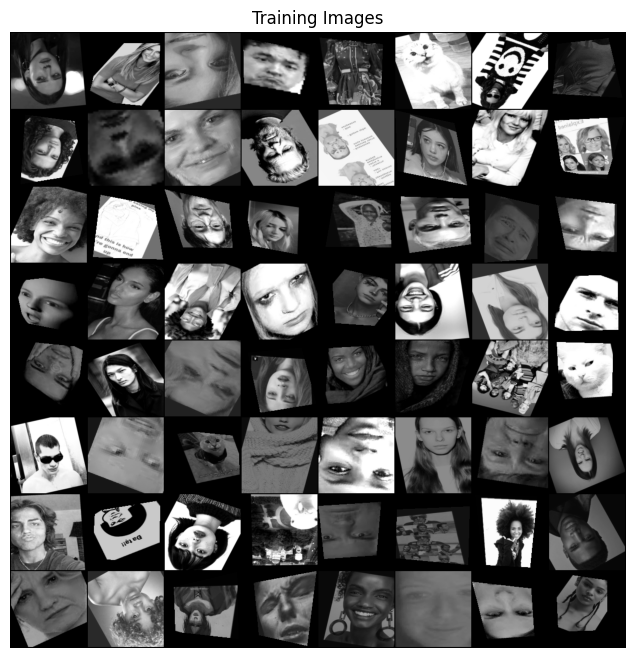

In [70]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define train_transform for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your training dataset
train_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train'

# Load the training dataset
train_set = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)

# Define DataLoader for batch loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Get a batch of training images
real_batch = next(iter(train_loader))
tensor_batch = real_batch[0]

# Convert a batch of PyTorch tensors to NumPy arrays
# Convert PyTorch tensors to NumPy arrays (had to convert PyTorch tensor to NumPy array, due to incorrect data processing.
# I used code adapted from: https://www.geeksforgeeks.org/how-to-convert-pytorch-tensor-to-numpy-array/ then debugged with GPT after my own attempt.

train_numpy = tensor_batch.numpy()
train_numpy = np.moveaxis(train_numpy, 1, -1)
print("Shape of train_numpy:", train_numpy.shape)

# Plot some training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# Display the grid of images 
# The below code was adapted from https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t, which explained the same issue where matplotlib was not displaying my images because of image sizing differences.
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

Shape of val_numpy: (707, 150, 150, 1)


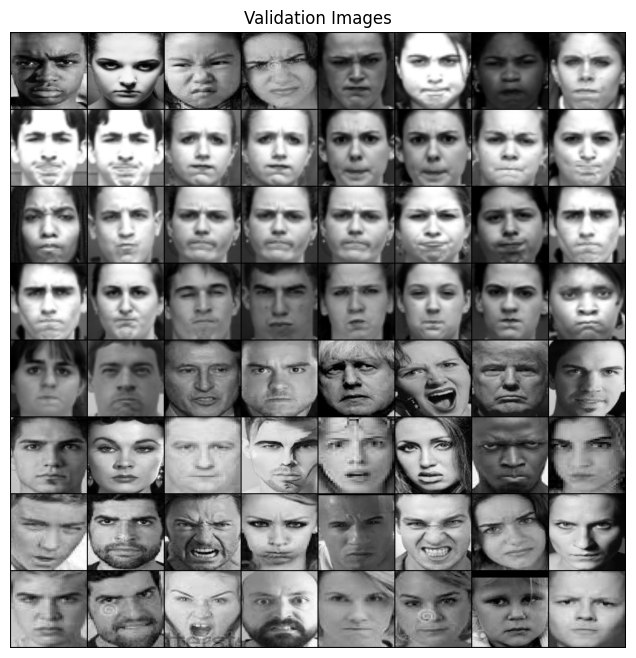

In [71]:
# Validation image transforms using the similar approach as train
import torchvision.datasets as datasets

val_transform = transforms.Compose([
    torchvision.transforms.Resize((150, 150)), 
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your validation dataset
val_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/validation'  # Path to the directory containing class directories

val_set = torchvision.datasets.ImageFolder(root=val_path, transform=val_transform)

# Convert to NumPy array for data processing ( same as the above training data)
# I had an issue with the dimensions of my images
val_numpy = np.array([x.numpy() for x, _ in val_set])

# Code adapted from: https://stackoverflow.com/questions/57438392/rearranging-axes-in-numpy after an error with the shape of val_numpy (374, 1, 150, 150).
    # The error: 'sequential_9". I have an error 'ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 150, 150, 1), found shape=(None, 1, 150, 150)'
val_numpy = np.moveaxis(val_numpy, 1, -1)

# Print shape 
print("Shape of val_numpy:", val_numpy.shape)

# Define DataLoader for batch loading
batch_size = 64
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Get a batch of validation images
real_batch = next(iter(val_loader))

# Convert torch tensor to numpy array and permute the dimensions to match (batch_size, height, width, channels)
tensor_batch = real_batch[0]

# Plot some validation images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validation Images")

# The code below displays the batch of images using matplotlib
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

### New Model

In [88]:
# Code debugged with GPT
# Code adapted from: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
from torch.utils.data import DataLoader
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


# Clear any previous session
tf.keras.backend.clear_session()

batch_size = 32

# I ran into a 'ValueError: Failed to find data adapter that can handle input: <class 'torchvision.datasets.folder.ImageFolder'>, <class 'NoneType'>' which suggested my data for the training and validation were not in an expected format before passing them into the model.fit() function
# The next two lines of code were suggested by GPT, converting PyTorch dataset to MumPy arrays, which then can be used with Keras.
#train_numpy = np.array(train_set)

# Convert DataLoader to NumPy arrays for training and validation sets
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size) ### Define val_set

train_numpy = []
train_labels = []
#train_labels_encoded = []

for data, labels in train_loader:
    data = data.numpy().transpose(0,2,3,1)
    train_numpy.append(data)
    #train_numpy.append(data.numpy())
    #train_labels.append(labels.numpy())
    train_labels.extend(labels.numpy().flatten())  # Flatten and extend instead of append


train_numpy = np.concatenate(train_numpy, axis=0)
train_labels = np.array(train_labels)
#train_labels_encoded = np.concatenate(train_labels_encoded, axis=0)
print("Train set converted!")

#train_numpy = np.concatenate(train_numpy, axis=0)
#train_labels_encoded = to_categorical(train_labels_encoded)

val_numpy = []
val_labels = []

for data, labels in val_loader:
    data = data.numpy().transpose(0,2,3,1)
    val_numpy.append(data)
    #data = np.transpose(data.numpy(), (0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)
    #val_labels.append(labels.numpy())
    val_labels.extend(labels.numpy().flatten())  # Flatten and extend instead of append


val_numpy = np.concatenate(val_numpy, axis=0)
val_labels = np.array(val_labels)
#val_labels = np.concatenate(val_labels, axis=0)
print("Validation set converted")

# Removing bias within model, as learnt from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/.
# Class weight calculations. I used the vectors assigned to each emotional class and implemennted a weight for each.
# The model seemed to have an affinity for predicting '2' (happy face) and '4' (sad face), suggesting bias. For these classes, I applied smaller weighting values.
#class_weights = {0: 1.0, 1: 1.0, 2: 0.5, 3: 1.0}
#class_weight_dict = dict(enumerate(class_weights))

# After running the model for few instances, i decided to tweak the weights manually for the underperforming weights
#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
#class_weight_dict = dict(enumerate(class_weights))

class_weights = { 0:0.8, # had moderate recall
                  1:0.8, # highest recall, thus weight decreased
                  2:1.0, # weight maintained
                  3:2.0} # lowest recall, thus weight increased

np.random.seed(42)

# Encode training labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Convert labels to categorical formatting for 4 classes 
#train_labels_encoded = to_categorical(train_labels_encoded, num_classes=4)
train_labels_categorical = to_categorical(train_labels_encoded, num_classes=4)
print("Train labels shape:", train_labels_categorical.shape)

val_labels_categorical = to_categorical(val_labels_encoded, num_classes=4)
print("Validation labels shape:", val_labels_categorical.shape)

# Define data augmentation to improve generalization
data_augmentation = ImageDataGenerator(
     rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

Train set converted!
Validation set converted
Train labels shape: (2819, 4)
Validation labels shape: (707, 4)


In [89]:
if train_numpy.ndim == 3:
    train_numpy = np.expand_dims(train_numpy, axis=-1)
print("Shape of train_numpy:", train_numpy.shape)

print("Shape of train_labels_categorical:", train_labels_categorical.shape)

Shape of train_numpy: (2819, 150, 150, 1)
Shape of train_labels_categorical: (2819, 4)


In [90]:
# Reinitialize the model
model = Sequential()

# 1st CNN layer with larger kernel size and L2 regularization
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) 

# 2nd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001))) # Added in L1 regularization to improve overfit. Code adapted from: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md.
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) 

# 3rd CNN layer
model.add(Conv2D(128, (3, 3), padding='same')) #kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Increased dropout rate

# 4th CNN layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Increased dropout rate

# 5th CNN layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Fully connected layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))


# learning rate schedule
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 75:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.5
    return lr

# Compile model
opt = Adam(learning_rate=0.0001)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

# Define callbacks and added EarlyAtopping which skips a decrease in improvement and helps the model train better,
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True) # Intoduced to reduce the learning rate when the model's performance plateaus.reduce the learning rate when the model's performance plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

history = model.fit(
    data_augmentation.flow(train_numpy, train_labels_categorical, batch_size=32),
    steps_per_epoch=len(train_numpy) // 32,
    epochs=50,
    validation_data=(val_numpy, val_labels_categorical),
    class_weight=class_weights,
    callbacks=callbacks_list)

/Users/nixi/Desktop/Final-thesis-folder-24/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,166,404 (8.26 MB)

 Trainable params: 2,163,396 (8.25 MB)

 Non-trainable params: 3,008 (11.75 KB)

RuntimeError: boundary mode not supported

In [ ]:
model.save_weights("model_weights.weights.h5") # Save model

In [50]:
# Save the entire model
model.save("model.keras")

### Plotting Accuracy

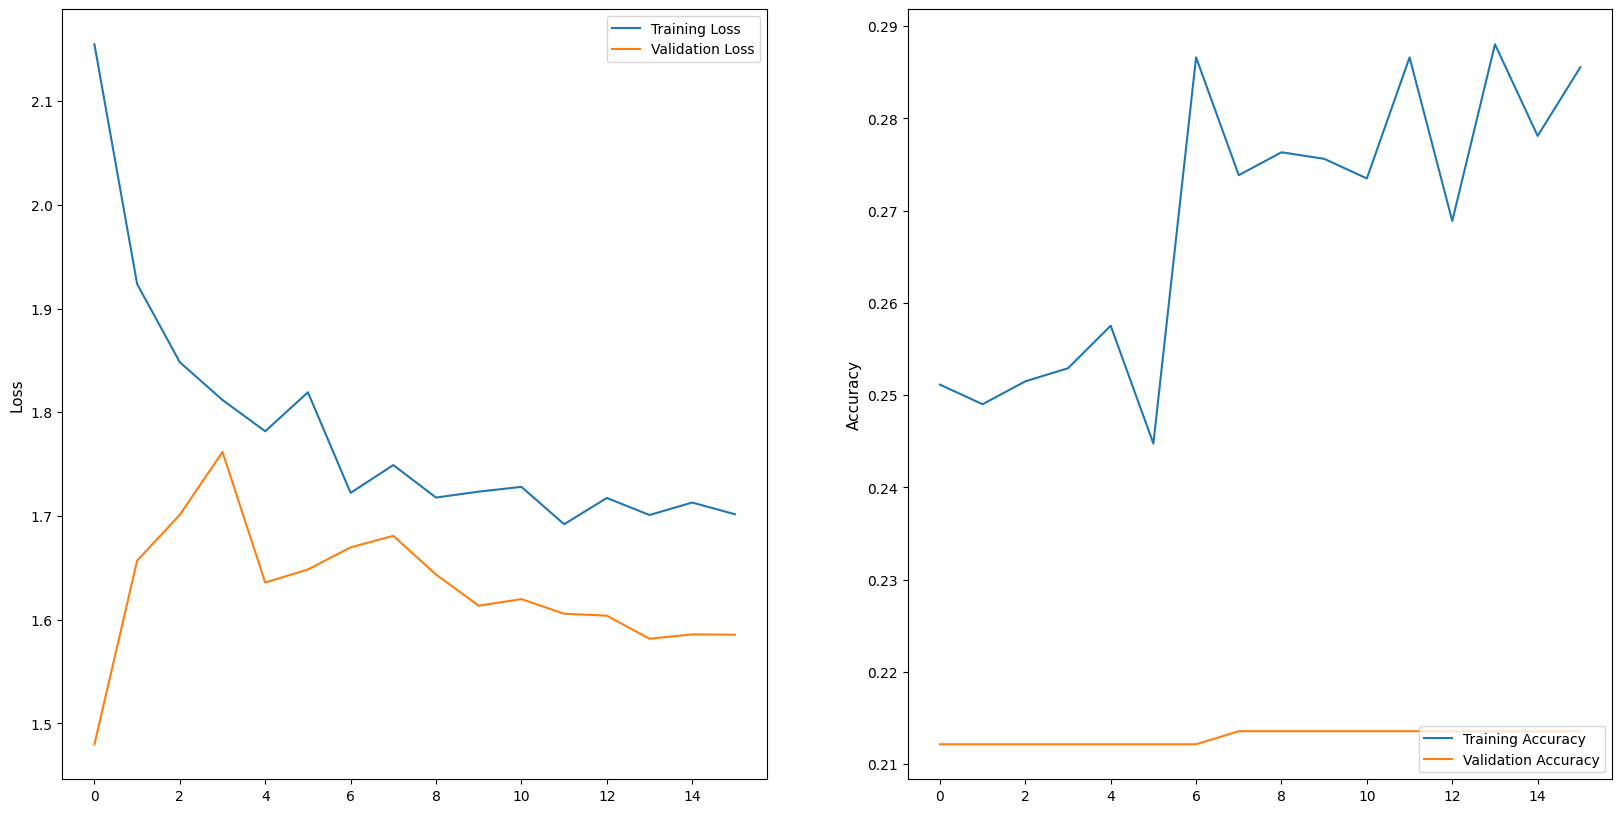

In [74]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=11)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=11)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [75]:
# Plot pecentage accuracy and loss for training and validation sets
# I asked GPT to fix the following two lines of code which retrievs the results of the val-train results. I did not know that [-1] was neeeded to fetch the last epoch results.
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Convert result into %
training_accuracy_percentage = final_training_accuracy * 100
validation_accuracy_percentage = final_validation_accuracy * 100

#Code adapted from: https://www.askpython.com/python/examples/print-a-percentage-value-in-python
print("Final Training Accuracy: {:.2f}%".format(training_accuracy_percentage))
print("Final Validation Accuracy: {:.2f}%".format(validation_accuracy_percentage))

Final Training Accuracy: 28.56%
Final Validation Accuracy: 21.36%


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step
Shape of true_labels: (707,)
First few true labels: [0 0 0 0 0]
Shape of predicted_labels: (707,)
First few predicted labels: [3 3 3 3 3]


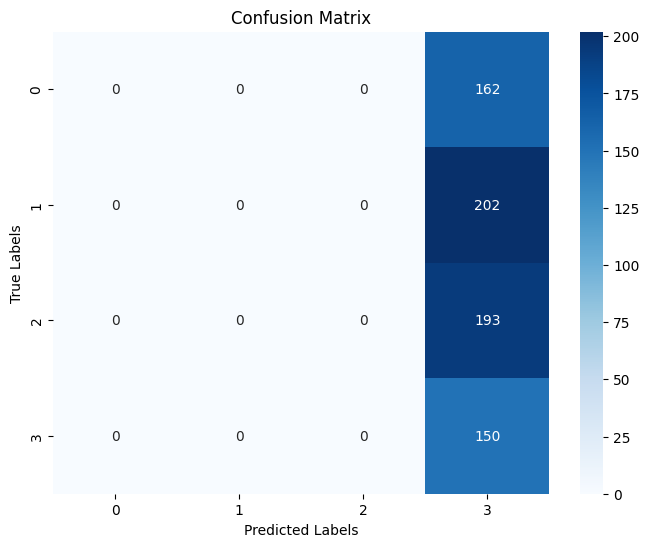

In [76]:
# Plot confusion matrix
# Code adapted from: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-4-Sensing-bodies/02-train-keypoints-classifier.ipynb.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make Predictions
predictions = model.predict(val_numpy)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Convert Predictions and True Labels
true_labels = val_labels_encoded

print("Shape of true_labels:", true_labels.shape)
print("First few true labels:", true_labels[:5])
print("Shape of predicted_labels:", predicted_labels.shape)
print("First few predicted labels:", predicted_labels[:5])

# Step 3: Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [59]:
print("Class weights:", class_weight_dict)
import matplotlib.pyplot as plt

plt.hist(train_labels_encoded, bins=np.arange(5)-0.5, edgecolor='black')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

from sklearn.metrics import classification_report

y_true = np.concatenate([y.numpy() for x, y in val_loader])
y_pred = model.predict(val_numpy)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_labels))


NameError: name 'class_weight_dict' is not defined

### What are my emotional classes?
Finding out which emotional class labels correspond to which emotion in my directory ( stored as one-hot) as made by ImageFolder.

In [72]:
# Code adapted using https://discuss.pytorch.org/t/how-to-get-the-class-names-to-class-label-mapping/470 and GPT for debugging.
import torchvision.datasets as datasets

# Print class info. Code adapted from: https://stackoverflow.com/questions/54734286/how-to-get-class-to-idx-map-for-custom-dataset-in-pytorch
for class_name, class_index in sorted(train_set.class_to_idx.items()):
    print(class_name,class_index)

angry-face 0
happy-face 1
neutral-face 2
sad-face 3


###  Model evaluation
Code adapted from: https://www.tutorialspoint.com/deep_learning_with_keras/deep_learning_with_keras_evaluating_model_performance.htm

In [60]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
loss, accuracy = model.evaluate(test_set)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3235 - loss: 63.8476
Test Loss: 69.32247924804688
Test Accuracy: 0.23620933294296265


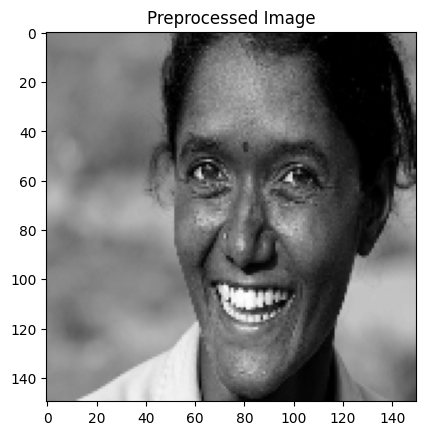

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Class Label: angry-face


In [61]:
import tensorflow as tf
import cv2

# Dowload a new image for classification and test the model to see the classification progress. 
# Code adapted from: https://github.com/MahdiNavaei/Emotion-Classification-with-CNN/blob/main/projrct.ipynb.
# I chose a happy face because the model seemed to always classify this emotion best and thus should be the quickest way to identify if the model works overall.

img=cv2.imread('new-image1.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# resize and add in grayscale to match the train and validation images
resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

#Load in model and image details to see which emotional class is predicted.
# Code also adapted from: https://www.tensorflow.org/tutorials/keras/save_and_load

model = tf.keras.models.load_model('model.keras')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)

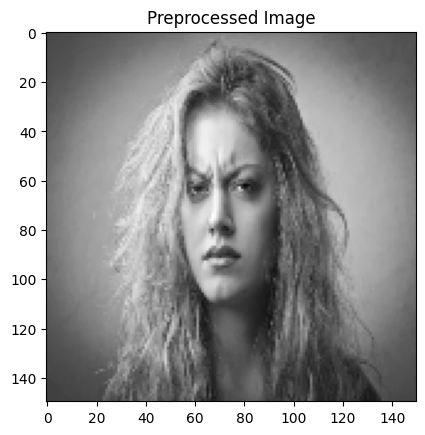

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted Class Label: angry-face


In [62]:
# What about other emotional classes e.g., anger
img=cv2.imread('new_image2.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.keras')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)



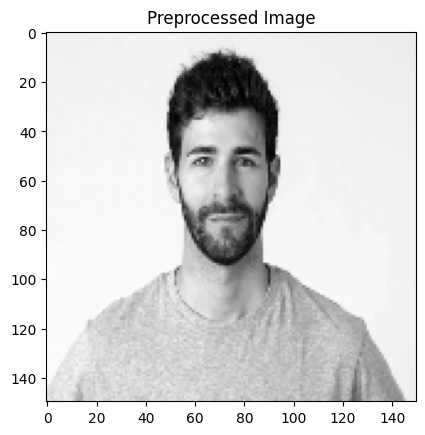

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted Class Label: sad-face


In [77]:
# What about other emotional classes e.g., neutral
img=cv2.imread('new_image3.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.keras')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)

 

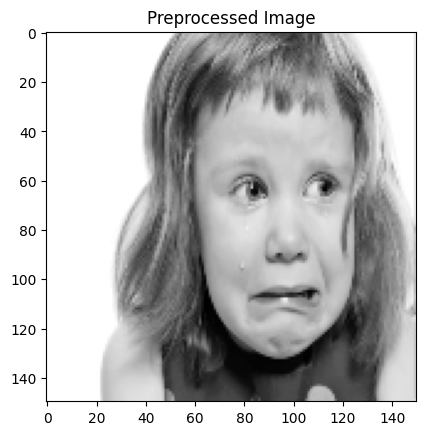

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted Class Label: sad-face


In [79]:
# What about other emotional classes e.g., sad
img=cv2.imread('new_image4.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.keras')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)



### Connect Model to Webcam 

In [75]:
# Can the classifier predict real-time expressions
%pip install opencv-python
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [80]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained Keras model
model = load_model('model_weights.keras')

# Define the emotion labels
labels = ['Happy', 'Sad', 'Neutral', 'Angry']  # Make sure this matches the order used in training

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Preprocess the frame to match the model input requirements
def preprocess_frame(frame):
    # Convert frame to grayscale if your model was trained on grayscale images
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize the frame to the size used during training, for example, 150x150 pixels
    resized_frame = cv2.resize(gray, (150, 150))
    # Normalize the frame values to the range [0, 1]
    normalized_frame = resized_frame / 255.0
    # Expand dimensions to match the input shape (1, 150, 150, 1)
    input_frame = np.expand_dims(normalized_frame, axis=-1)
    input_frame = np.expand_dims(input_frame, axis=0)
    return input_frame

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame for prediction
    processed_frame = preprocess_frame(frame)

    # Predict the emotion using the CNN model
    predictions = model.predict(processed_frame)
    predicted_class = np.argmax(predictions)
    predicted_emotion = labels[predicted_class]

    # Debug: Print the raw prediction probabilities
    print(f"Predictions: {predictions}, Predicted Emotion: {predicted_emotion}")

    # Display the predicted emotion on the frame
    cv2.putText(frame, predicted_emotion, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Show the frame with the prediction
    cv2.imshow('Emotion Prediction', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predictions: [[0.34029818 0.04488213 0.1441704  0.47064933]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predictions: [[0.31474495 0.09493612 0.22853804 0.3617809 ]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predictions: [[0.31639686 0.09582997 0.22865857 0.3591146 ]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predictions: [[0.31826347 0.09708866 0.2291749  0.35547292]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predictions: [[0.3184228  0.09918436 0.23100485 0.35138792]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predictions: [[0.31874377 0.10021568 0.23180284 0.34923774]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predictions: [[0.3195648  0.10127097 0.23230968 0.3468546 ]], Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predictions: [[0.32074553 0.10078909 0.23121873 0.34724668]], Predicted Emotion: Angry

: 

### Evaluation
Objective:
- To evaluate the performance of the model for real-time emotion detection across different lighting conditions and diverse participants

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import time

# Load the trained Keras model
model = load_model('model_weights.keras')

# Define the emotion labels
labels = ['Happy', 'Sad', 'Neutral', 'Angry']

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Function to preprocess the frame to match the model input requirements
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray, (150, 150))
    normalized_frame = resized_frame / 255.0
    input_frame = np.expand_dims(normalized_frame, axis=-1)
    input_frame = np.expand_dims(input_frame, axis=0)
    return input_frame

# Define variables to keep track of performance
frame_count = 0
correct_predictions = 0
total_time = 0

# Expected emotion (set manually during tests or dynamically based on scenario)
expected_emotion = 'Happy'  # Change based on test scenario

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame for prediction
    start_time = time.time()
    processed_frame = preprocess_frame(frame)

    # Predict the emotion using the CNN model
    predictions = model.predict(processed_frame)
    predicted_class = np.argmax(predictions)
    predicted_emotion = labels[predicted_class]
    end_time = time.time()

    # Calculate the time taken for prediction
    prediction_time = end_time - start_time
    total_time += prediction_time

    # Compare with the expected emotion
    if predicted_emotion == expected_emotion:
        correct_predictions += 1

    # Display the predicted emotion on the frame
    cv2.putText(frame, f'Predicted: {predicted_emotion}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(frame, f'Expected: {expected_emotion}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    cv2.putText(frame, f'Prediction Time: {prediction_time:.2f}s', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Show the frame with the prediction
    cv2.imshow('Emotion Prediction', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

# Calculate real-time accuracy
accuracy = correct_predictions / frame_count * 100
average_time_per_frame = total_time / frame_count

print(f'Real-Time Accuracy: {accuracy:.2f}%')
print(f'Average Prediction Time per Frame: {average_time_per_frame:.2f} seconds')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

: 